In [1]:
# imports 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# draw plots in notebook not new window

In [37]:
# load data
from tensorflow.examples.tutorials.mnist import input_data
'''
switch for Fashion or Digits Data set
'''
# mn = input_data.read_data_sets("./MNIST_DATA",one_hot=True)        
mn = input_data.read_data_sets("./FASHION_DATA",one_hot=True)

Extracting ./FASHION_DATA/train-images-idx3-ubyte.gz
Extracting ./FASHION_DATA/train-labels-idx1-ubyte.gz
Extracting ./FASHION_DATA/t10k-images-idx3-ubyte.gz
Extracting ./FASHION_DATA/t10k-labels-idx1-ubyte.gz


shape of image is:  (784,)


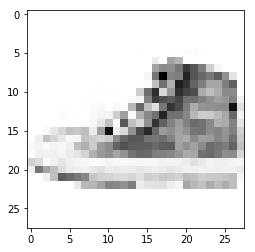

In [38]:
print('shape of image is: ', mn.train.images[0].shape)          # image is a long flat vector
# plt.imshow(mn.train.images[23].reshape(28,28), cmap="Greys")     # reformat long flat img vector in to 28x28 square img
plt.imshow(mn.train.images[2].reshape(28,28), cmap="Greys")     # reformat long flat img vector in to 28x28 square img

In [4]:
# define generator/faker net with own var_scope
def gen(z, reuse=None, extra_layer=0):
    '''
    input: takes random seed z 
    outputs: a 784 pixel img vector
    '''
    with tf.variable_scope('gen', reuse=reuse):
        leaky_relu_const = 0.01 # using RELU (sparse activation) causes instability, use leaky relu
        hid1 = tf.layers.dense(inputs=z, units=128)
        hid1 = tf.maximum(leaky_relu_const*hid1, hid1)
        hid2 = tf.layers.dense(inputs=hid1, units=128)
        hid2 = tf.maximum(leaky_relu_const*hid2, hid2)
        if extra_layer:
            hid3 = tf.layers.dense(inputs=hid2, units=256)
            hid3 = tf.maximum(leaky_relu_const*hid3, hid3)
            outl = tf.layers.dense(hid3, units=784, activation=tf.nn.tanh)
        else:
            outl = tf.layers.dense(hid2, units=784, activation=tf.nn.tanh)
        return outl

In [5]:
# define descriminator/judge net with own var_scope
def judge(x, reuse=None, extra_layer=0):
    '''
    input: a 784 pixel img vector (either generated by the faker or a real example from MNIST)
    output: tuple (Boolean (0 or 1) where 1 = image is real (MNIST) and not generated, prediction proability)
    '''
    with tf.variable_scope('jud', reuse=reuse):
        hid1 = tf.layers.dense(inputs=x, units=128)
        leaky_relu_const = 0.01 
        hid1 = tf.maximum(leaky_relu_const*hid1, hid1)
        hid2 = tf.layers.dense(inputs=hid1, units=128)
        hid2 = tf.maximum(leaky_relu_const*hid2, hid2)
        if extra_layer:
            hid3 = tf.layers.dense(inputs=hid2, units=256)
            hid3 = tf.maximum(leaky_relu_const*hid3, hid3)
            logits = tf.layers.dense(hid3, units=1)
        else:
            logits = tf.layers.dense(hid2, units=1)
        outl = tf.sigmoid(logits)
        return outl, logits

In [6]:
# define placeholders
extra_layer=False # use 1 for fashion, 0 for MNIST
real_img = tf.placeholder(tf.float32, shape=[None, 784])
z= tf.placeholder(tf.float32, shape=[None, 100])  # random seed for the faker


G = gen(z, extra_layer=extra_layer) # initate a faker

In [7]:
JoutReal, JlogitsReal = judge(real_img, extra_layer=extra_layer)  # this is a tensorFlow node, this version takes in real MNIST images
JoutFake, JlogitsFake = judge(G, reuse=True, extra_layer=extra_layer) # this is a tensorFlow node, this version takes in faked images

In [8]:
# losses: how "off" was the model?
def lossfunc (logitsin, yin):
    '''
    for each 0/1 prediction, calculate the error, and return the average for the batch
    '''
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logitsin, labels=yin))

In [9]:
# define labels (either 0 or 1 because we know if the image is a fake or real MNIST data)
JlossReal = lossfunc(JlogitsReal, tf.ones_like(JlogitsReal)*0.90) 
'''
tf.ones_like(JlogitsReal)*0.9 is applying a smoothing factor to real images (lablel = 1) 
so the model genearlize better
'''
JlossFake = lossfunc(JlogitsFake, tf.zeros_like(JlogitsFake))
Jloss = JlossReal + JlossFake # overall error for the judge-net

'''
overall error for the faker net, it doesn't care about loss on real MNIST images
is labeled 1 (a lil counter-intuitive maybe):
- but since if the judge thinks the image is real, it'll output value "1"
- then the generator won, we want to label genenerator images with 1 
(other wise we would be punishing the generator for it's sucess)
'''
Gloss=lossfunc(JlogitsFake, tf.ones_like(JlogitsFake))

In [10]:
# define visualizer function

skip = 5

def visualize_sample(imgarray, pos, greyscale=0):
    img = imgarray.reshape(28,28)
    fig = plt.figure()
    fig.suptitle("after {} epochs".format(pos), fontsize=14, fontweight='bold')
    if greyscale == 1:
        plt.imshow(img, cmap='Greys')
    else: 
        plt.imshow(img)
        

In [11]:
# define pipeline parameters

batchsz=100 # number of images processed before we make a update
rounds = 256 # number of times we train over the whole data-set
samples = [] # a array to store the random samples at each epoch
lr = 0.001 # learning rate

# define what to optimize
allvars = tf.trainable_variables()
jvars = [var for var in allvars if 'jud' in var.name]
gvars = [var for var in allvars if 'gen' in var.name]

jtrain = tf.train.AdamOptimizer(lr).minimize(Jloss, var_list=jvars) # train judge only
gtrain = tf.train.AdamOptimizer(lr).minimize(Gloss, var_list=gvars) # train generator only

init = tf.global_variables_initializer()

In [36]:
with tf.Session() as sess:
    sess.run(init) 
    for e in range(rounds):
        nbatch = mn.train.num_examples // batchsz
        # train the network for 1 batch (there are # of Images/Bach_size batches in each epoch)
        for i in range(nbatch):
            batch = mn.train.next_batch(batchsz) # get the next batch of training data
            batchimgs = batch[0].reshape((batchsz, 784))
            batchimgs = batchimgs * 2 - 1 # adjust values for tanh activation, batch imgs are pre-normalized
            batch_z = np.random.uniform(-1,1,size=(batchsz,100)) # generate random seed batch for faker
            sess.run(jtrain, feed_dict={real_img: batchimgs, z: batch_z}) # train one batch on judge
            sess.run(gtrain, feed_dict={z:batch_z}) # train one batch on faker
        print("on epoch {}".format(e))
        samplez = np.random.uniform(-1,1,size=(1,100))  # make random seed vector for sampling
        fakeimg = sess.run(gen(z, reuse=True, extra_layer=extra_layer), feed_dict={z: samplez}) # make fake images
        samples.extend(fakeimg)

In [44]:
'''
code to save and load results
uncomment to (switch) save the appropriate sample vector file
'''


'''
np.save('./samples_250t', samples) 
'''
# res = np.load('./samples_250t_1.npy')


'''
np.save('./samples_250t_FASHION2', samples) 
'''

res = np.load('./samples_250t_FASHION2.npy') # './samples_250_FASHION.npy'

loaded_samples = res # res

/Users/mengningshang/Desktop/Dev_Env/carAI/CarND-Alexnet-Feature-Extraction/wcd-ml-b2/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


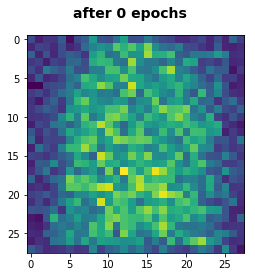

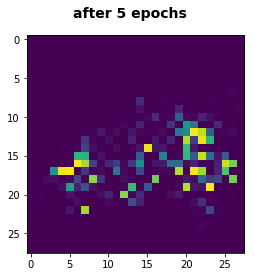

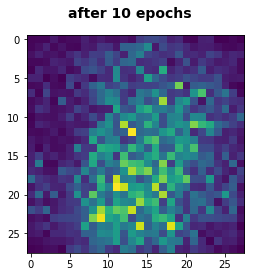

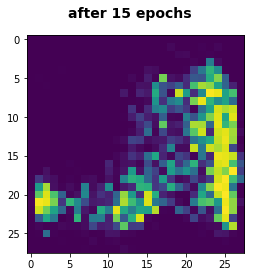

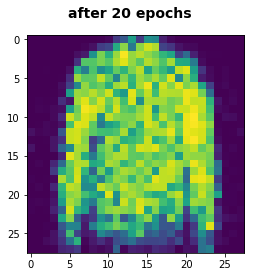

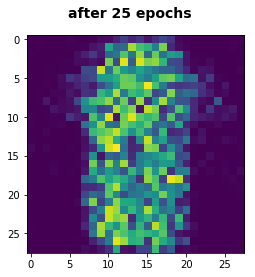

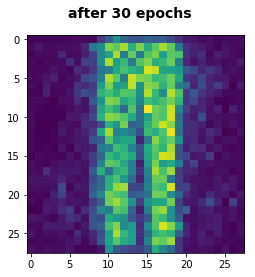

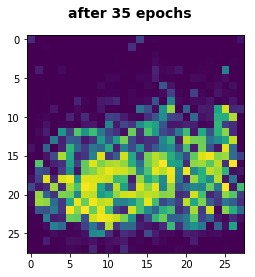

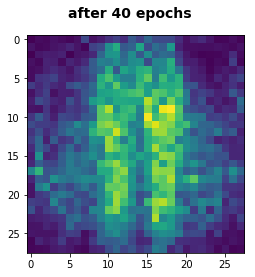

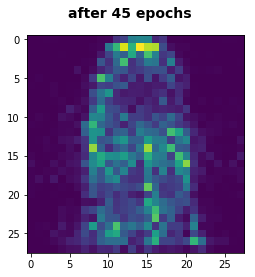

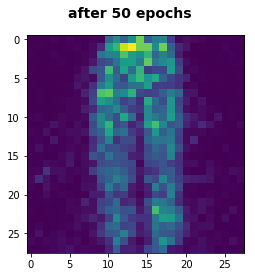

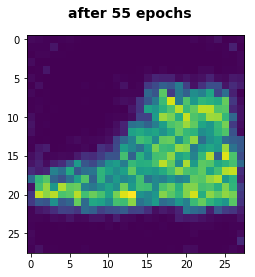

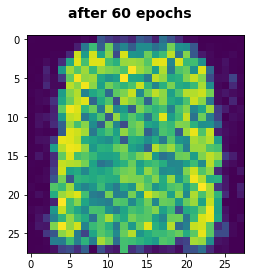

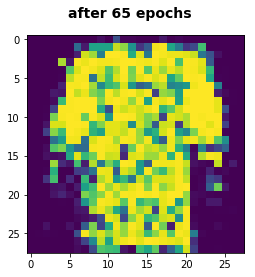

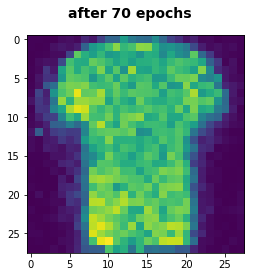

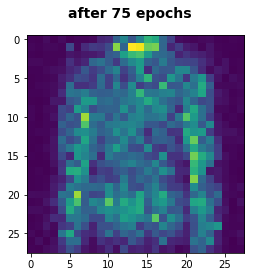

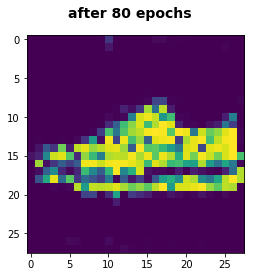

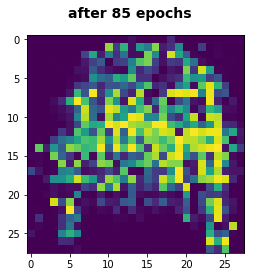

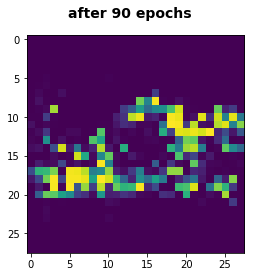

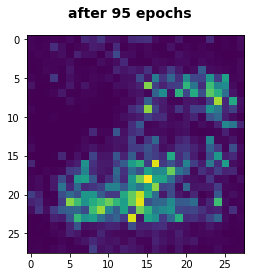

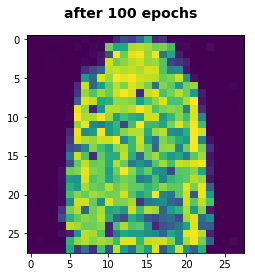

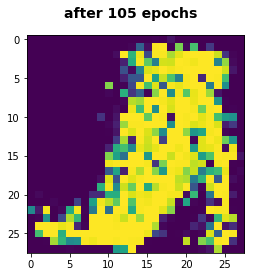

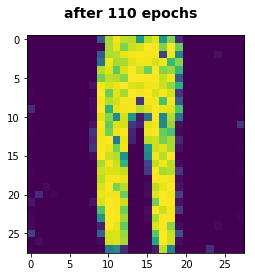

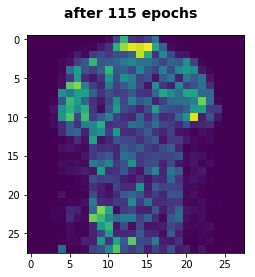

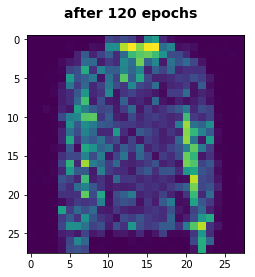

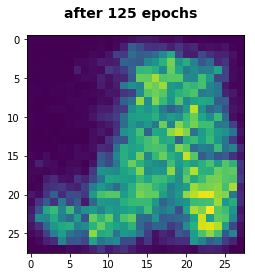

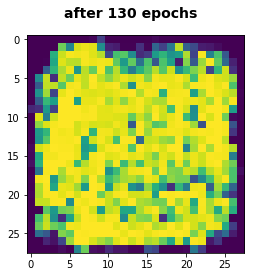

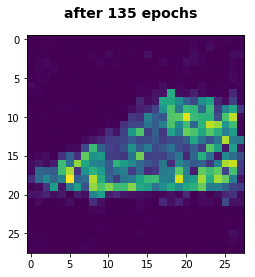

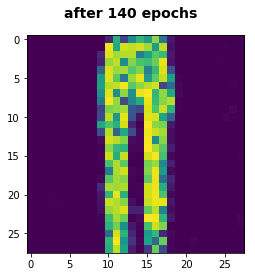

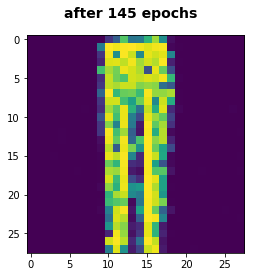

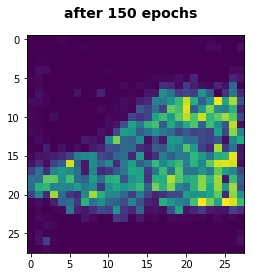

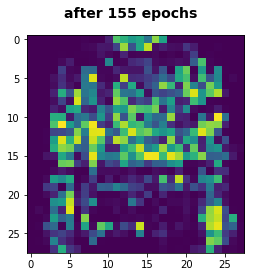

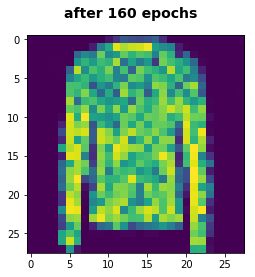

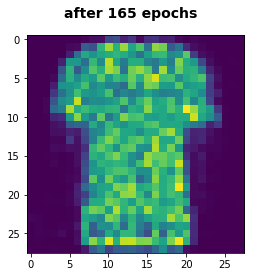

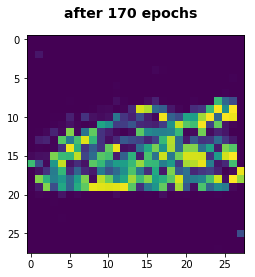

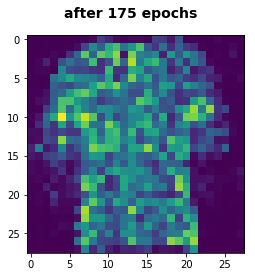

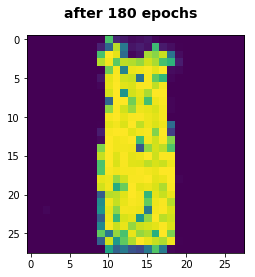

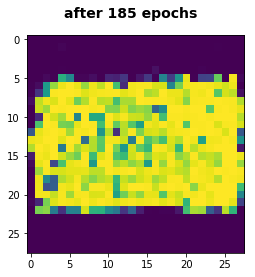

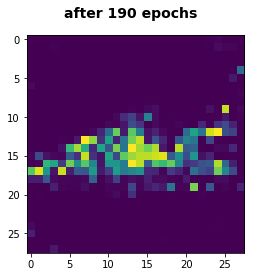

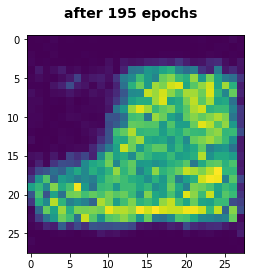

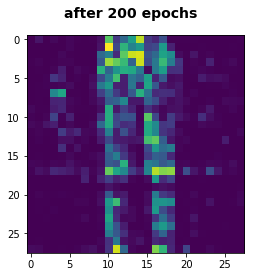

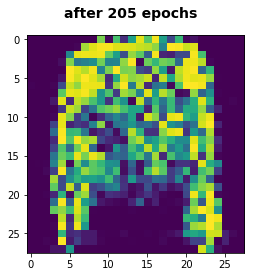

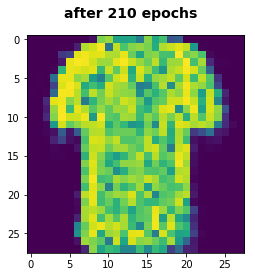

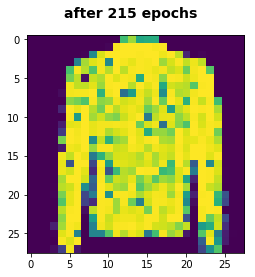

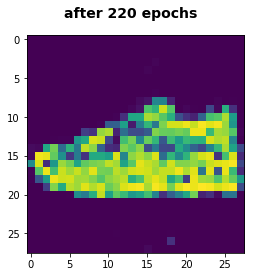

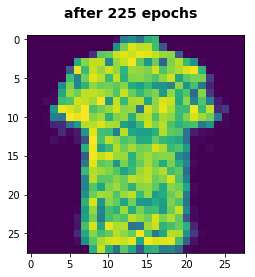

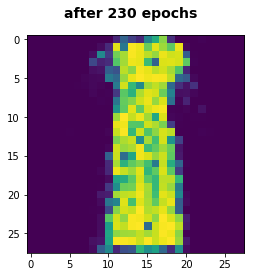

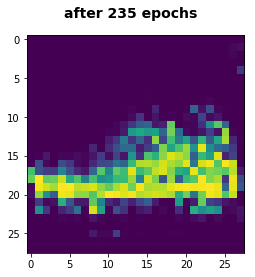

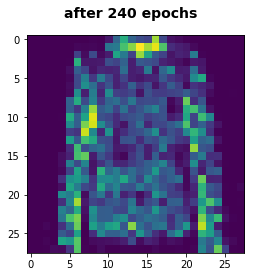

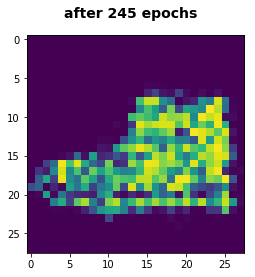

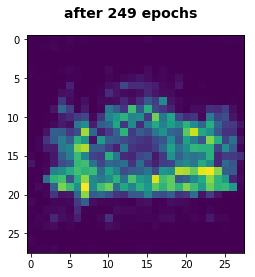

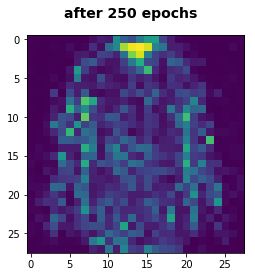

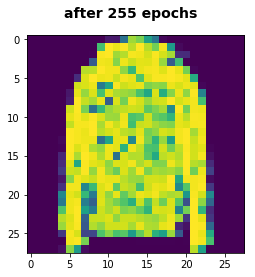

In [45]:
for pos, imgs in enumerate(loaded_samples):
    if pos%skip ==0 or pos==250-1 :
            visualize_sample(imgs, pos)

In [15]:
len(samples)

256